<a href="https://colab.research.google.com/github/israel-adewuyi/micrograd/blob/main/understanding_micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f1(x):
    return 3*x**2 - 4 * x - 5

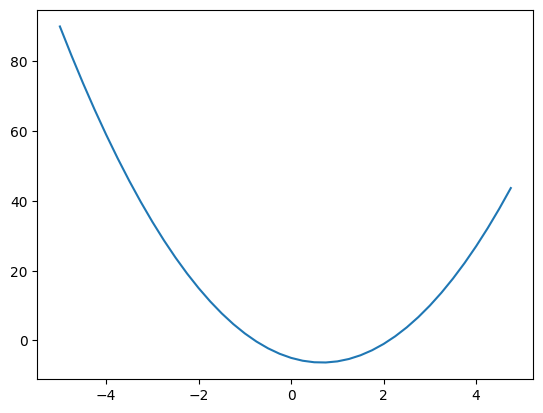

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f1(xs)
plt.plot(xs, ys)

In [4]:
h = 0.0000001
x = -4


(f1(x + h) - f1(x)) / h

-27.999999616667992

In [5]:
a = 2.0
b = -3.0
c = 10
d = (a * b) + c
print(d)

4.0


In [6]:
h = 0.000001

a = 2.0
b = -3.0
c = 10


d1 = (a * b) + c

d2 = ((a + h) * b) + c

d3 = (a * (b + h)) + c

d4 = (a * b) + (c + h)

print('d1', d1)
print('dd/da', (d2 - d1) / h)
print('dd/db', (d3 - d1) / h)
print('dd/dc', (d4 - d1) / h)

d1 4.0
dd/da -3.000000000419334
dd/db 2.000000000279556
dd/dc 0.9999999992515995


In [78]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, (self, other), '+')

        def _backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
      return self + other

    def __rsub__(self, other):
      return other - self

    def __neg__(self): # -self
      return self * -1

    def __sub__(self, other): # self - other
      other = other if isinstance(other, Value) else Value(other)
      return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self, other), '*')

        def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
      return self * other

    def __truediv__(self, other):
      return self * other**-1

    def __pow__(self, other):
      assert isinstance(other, (int, float)), "only supporting int/float powers for now"
      out = Value(self.data**other, (self,), f'**{other}')

      def _backward():
          self.grad += other * (self.data ** (other - 1)) * out.grad
      out._backward = _backward

      return out

    def exp(self):
      x = self.data
      out = Value(math.exp(x), (self, ), 'exp')

      def _backward():
        self.grad = out.data * out.grad
      out._backward = _backward

      return out

    def tanh(self):
      x = self.data
      t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
      out = Value(t, (self, ), 'tanh')

      def _backward():
        self.grad += (1 - t**2) * out.grad
      out._backward = _backward
      return out


    def backward(self):
      visited = set()
      topo = []

      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)
      build_topo(self)

      self.grad = 1
      for node in reversed(topo):
        node._backward()


In [8]:
a = Value(5)
b = Value(2)

a - b

Value(data=3)

In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

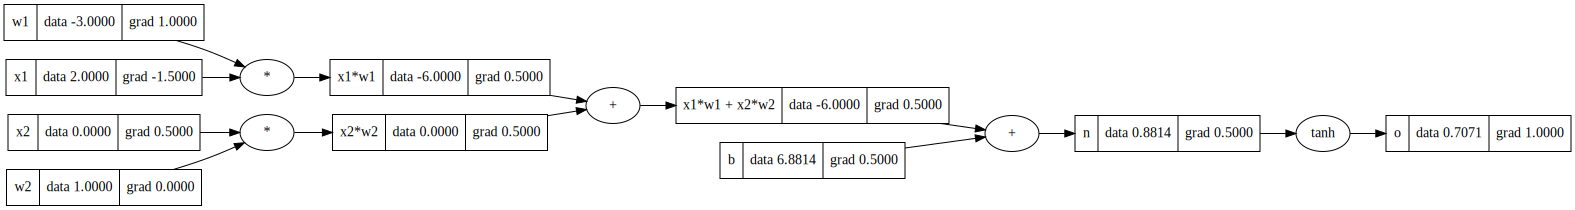

In [11]:
draw_dot(o)

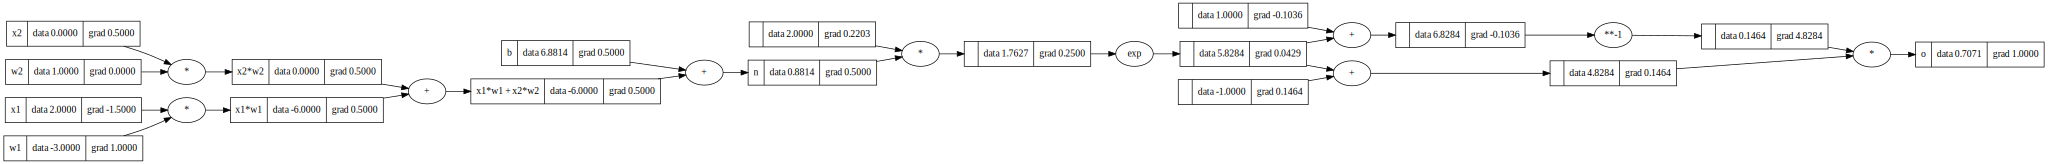

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [13]:
import torch

x1 = torch.Tensor([2.0]).double();  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();  w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = (x1 * w1) + (x2 * w2) + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [89]:
import random
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))


  def __call__(self, x):
    activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = activation.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    # return outs
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [97]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=-0.4055763248122469)

In [98]:
len(mlp.parameters())

41

In [102]:
#Testing out micrograd back propagation
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [103]:
for k in range(100):
  # forward pass
  ypred = [mlp(xs[i]) for i in range(len(xs))]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in mlp.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in mlp.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 0.008068498644638553
1 0.007977263494373537
2 0.00788799211123668
3 0.007800622810217522
4 0.007715096437601227
5 0.007631356243317929
6 0.007549347760901359
7 0.007469018694534649
8 0.007390318812702375
9 0.007313199848003213
10 0.00723761540271336
11 0.00716352085971992
12 0.00709087329847338
13 0.007019631415632931
14 0.006949755450103387
15 0.006881207112183381
16 0.006813949516565467
17 0.006747947118946709
18 0.0066831656560258895
19 0.0066195720886783015
20 0.006557134548115172
21 0.0064958222848460765
22 0.006435605620276973
23 0.006376455900786408
24 0.006318345454134283
25 0.006261247548065807
26 0.006205136350984058
27 0.006149986894571223
28 0.006095775038247938
29 0.00604247743536563
30 0.0059900715010352615
31 0.005938535381500649
32 0.005887847924970892
33 0.005837988653831894
34 0.005788937738161477
35 0.00574067597047805
36 0.005693184741655733
37 0.0056464460179449245
38 0.005600442319038395
39 0.005555156697129273
40 0.00551057271690838
41 0.005466674436452601
42 0

In [104]:
ypred

[Value(data=0.9742013205307906),
 Value(data=-0.9828615959119856),
 Value(data=-0.9591210128049641),
 Value(data=0.966952188549073)]